# Inteligência Artificial Aplicada a Finanças

# Projeto 1 - Previsão de Lucro em Ativos Financeiros com IA

# Visualização do Resultado de Treinamento do Agente

In [1]:
!pip install -U altair vega_datasets notebook vega

Requirement already up-to-date: altair in /Users/dmpm/anaconda3/lib/python3.7/site-packages (3.1.0)
Requirement already up-to-date: vega_datasets in /Users/dmpm/anaconda3/lib/python3.7/site-packages (0.7.0)
Requirement already up-to-date: notebook in /Users/dmpm/anaconda3/lib/python3.7/site-packages (6.0.0)
Requirement already up-to-date: vega in /Users/dmpm/anaconda3/lib/python3.7/site-packages (2.4.0)


In [2]:
# Imports
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns

## Parâmetros

In [3]:
treina_stock = 'data/GOOGL.csv'
val_stock = 'data/GOOGL_2018.csv'
window_size = 10
batch_size = 16
ep_count = 10
model_name = 'modelo_stock'
pretrained = False
debug = False

## Carrega o dataset de validação

In [4]:
# Cria o dataframe
df = pd.read_csv(val_stock)

# Filtra as colunas desejadas
df = df[['Date', 'Adj Close']]

# Renomeia as colunas
df = df.rename(columns={'Adj Close': 'actual', 'Date': 'date'})

df.head()

,date,actual
0,2017-08-10,923.590027
1,2017-08-11,930.090027
2,2017-08-14,938.929993
3,2017-08-15,938.080017
4,2017-08-16,944.270020


In [5]:
# Converte datas para datetime
dates = df['date']
dates = pd.to_datetime(dates, infer_datetime_format=True)
df['date'] = dates

In [6]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
date      253 non-null datetime64[ns]
actual    253 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


,date,actual
0,2017-08-10,923.590027
1,2017-08-11,930.090027
2,2017-08-14,938.929993
3,2017-08-15,938.080017
4,2017-08-16,944.270020


## Visualização de ações tomadas pelo Stock Asset DSA Bot

In [7]:
def visualize(df, history):
    # Adiciona histórico para o dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['Aguardar'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    # Stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # Stock positions
    actual = alt.Chart(df).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='date:T',
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Preço'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # Compra e Venda
    points = alt.Chart(df).transform_filter(
        alt.datum.action != 'Aguardar'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('date:T', axis=alt.Axis(title='Data')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Preço'), scale=scale),
        color='action'
    ).interactive(bind_y=False)

    # Merge
    chart = alt.layer(actual, points, title='Previsões do Modelo Durante o Treinamento').properties(height=300, width=1000)
    
    return chart

## Treinamento

In [8]:
import logging
import coloredlogs

from treino import *
from executa import show_eval_result

coloredlogs.install(level='DEBUG')
switch_k_backend_device()

agente = Agente(window_size, pretrained=pretrained, model_name=model_name)
train_data = get_stock_data(treina_stock)
val_data = get_stock_data(val_stock)

initial_offset = val_data[1] - val_data[0]

for i in range(1, ep_count + 1):
    train_result = train_model(agente, i, train_data, ep_count=ep_count, batch_size=batch_size, window_size=window_size)
    val_result, _ = evaluate_model(agente, val_data, window_size, debug)
    show_train_result(train_result, val_result, initial_offset)

Using TensorFlow backend.
I0719 21:33:03.475404 4439803328 treino.py:160] Mudando para TensorFlow com CPU
2019-07-19 21:33:03 falcon.vf.shawcable.net root[76470] DEBUG Mudando para TensorFlow com CPU
Epoch 1/10: 100%|██████████| 1760/1760 [00:16<00:00, 105.92it/s]
I0719 21:33:20.323407 4439803328 treino.py:152] Epoch 1/10 - Posição em Treino: +$5.62  Posição em Validação: +$1708.05  Perda em Treino: 0.3235  (~19.8998 segundos)
2019-07-19 21:33:20 falcon.vf.shawcable.net root[76470] INFO Epoch 1/10 - Posição em Treino: +$5.62  Posição em Validação: +$1708.05  Perda em Treino: 0.3235  (~19.8998 segundos)
Epoch 2/10: 100%|██████████| 1760/1760 [00:13<00:00, 128.30it/s]
I0719 21:33:34.098607 4439803328 treino.py:152] Epoch 2/10 - Posição em Treino: +$506.59  Posição em Validação: +$1381.98  Perda em Treino: 0.5897  (~17.0621 segundos)
2019-07-19 21:33:34 falcon.vf.shawcable.net root[76470] INFO Epoch 2/10 - Posição em Treino: +$506.59  Posição em Validação: +$1381.98  Perda em Treino: 0.58

## Plot das ações do modelo durante o treinamento

In [9]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

I0719 21:35:32.024206 4439803328 executa.py:115] modelo_stock previu lucro de: +$52.34

2019-07-19 21:35:32 falcon.vf.shawcable.net root[76470] INFO modelo_stock previu lucro de: +$52.34



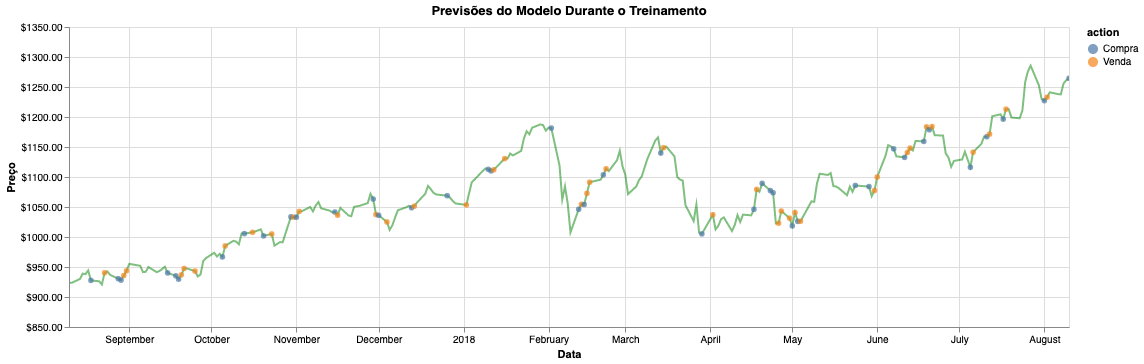

In [10]:
val_result, history = evaluate_model(agente, val_data, window_size, debug)
show_eval_result(model_name, val_result, initial_offset)
chart = visualize(df, history)
chart

# Fim